In [1]:
import pandas as pd
import numpy as np

# Load the data

## Word occurrences

In [2]:
lists = {}
files = ["k07_oplen", "rdoc_domain_opsim", "dsm_class_opsim"]
labels = ["kmeans", "rdoc", "dsm"]
words = []
for label, file in zip(labels, files):
    lists[label] = pd.read_csv("../lists/lists/lists_{}.csv".format(file), index_col=None)
    words += list(lists[label]["TOKEN"])

In [3]:
words = sorted(list(set(words)))
len(words)

297

In [4]:
def mean_thres(df):
    col_mean = df.mean()
    df_bin = np.empty((df.shape[0], df.shape[1]))
    i = 0
    for col, doc_mean in col_mean.iteritems():
        df_bin[:,i] = 1 * (df[col] > doc_mean)
        i += 1
    df_bin = pd.DataFrame(df_bin, columns=df.columns, index=df.index)
    return df_bin

In [5]:
dtm = pd.read_csv("../data/dtm_190325.csv.gz", compression="gzip", index_col=0)
dtm_bin = mean_thres(dtm)

## Activation coordinates

In [6]:
act_bin = pd.read_csv("../data/dcm_0mm_thres0.csv", index_col=0) # Previously binarized

In [7]:
pmids = act_bin.index.intersection(dtm_bin.index)
len(pmids)

18155

In [8]:
act_bin = act_bin.loc[pmids]
dtm_bin = dtm_bin.loc[pmids]

In [9]:
vecs = act_bin.copy()
vecs[words] = dtm_bin[words]
vecs.shape

(18155, 411)

## System assignments

In [10]:
systems = {}
files = ["kmeans_k07", "rdoc_domain", "dsm_class"]
for label, file in zip(labels, files):
    systems[label] = pd.read_csv("../mod/data/doc2dom_{}.csv".format(file), index_col=0, header=None) - 1

# Reduce dimensions with PCA

In [11]:
from sklearn.decomposition import PCA

In [12]:
pca = PCA(n_components=None, copy=True, whiten=False, svd_solver="auto", 
          tol=0.0, iterated_power="auto", random_state=42)

In [13]:
X_pca = pca.fit_transform(vecs)

In [14]:
X_pca.shape

(18155, 411)

# Fit a T-SNE model

In [15]:
from sklearn.manifold import TSNE

In [66]:
perplexity = 50.0
early_exaggeration = 15.0
learning_rate = 500.0
n_iter = 10000
PCs = 10

In [67]:
tsne = TSNE(n_components=2, perplexity=perplexity, early_exaggeration=early_exaggeration, 
            learning_rate=learning_rate, n_iter=n_iter, n_iter_without_progress=300, 
            min_grad_norm=1e-07, metric="cosine", init="random", verbose=0, 
            random_state=42, method="barnes_hut", angle=0.5)

In [68]:
X = tsne.fit_transform(X_pca[:,:PCs])

In [69]:
X_df = pd.DataFrame(X, index=vecs.index, columns=["X", "Y"])
X_df.to_csv("data/tsne_{}pcs_perp{}_exag{}_lr{}_iter{}.csv".format(
            PCs, int(perplexity), int(early_exaggeration), 
            int(learning_rate), int(n_iter)))

# Plot the results

In [70]:
import matplotlib.pyplot as plt

In [71]:
palette = {
           "kmeans": ["#7D74A3", # Purple
                      "#CE7D69", # Red
                      "#B07EB6", # Magenta
                      "#BA7E39", # Orange
                      "#77B58A", # Green
                      "#778AA3", # Blue
                      "#CEBE6D"], # Yellow
           
           "rdoc": ["#778AA3", # Blue
                    "#CE7D69", # Red
                    "#77B58A", # Green
                    "#7D74A3", # Yellow
                    "#CEBE6D", # Purple
                    "#BA7E39"], # Orange
           
           "dsm": ["#7D74A3", # Purple
                   "#D1E29E", # Chartreuse
                   "#BA7E39", # Orange
                   "#778AA3", # Blue
                   "#CE7D69", # Red
                   "#B07EB6", # Magenta
                   "#CEBE6D", # Yellow
                   "#77B58A"] # Green
          }

In [72]:
colors = {}
for label in labels:
    colors[label] = [palette[label][int(systems[label].loc[pmid])] for pmid in vecs.index]

In [73]:
shapes = {
    "kmeans": ["s", "<", "v", "X", ">", "o", "^"],
    "rdoc": ["o", "v", "^", ">", "<", "s"],
    "dsm": ["o", "v", "^", ">", "<", "s", "X", "D"]
}

In [74]:
markers = {}
for label in labels:
    markers[label] = [shapes[label][int(systems[label].loc[pmid])] for pmid in vecs.index]

In [75]:
def plot_tsne(system):
    fig, ax = plt.subplots(figsize=(8,8))
    for i in range(X.shape[0]):
        plt.scatter(X[i,0], X[i,1], c=colors[system][i], 
                    marker=markers[system][i], alpha=0.525, s=13)
    plt.xticks([])
    plt.yticks([])
    for side in ["top", "bottom", "left", "right"]:
        ax.spines[side].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/tsne_{}_{}pcs_perp{}_exag{}_lr{}_iter{}.png".format(system, PCs,
                int(perplexity), int(early_exaggeration), int(learning_rate), int(n_iter)), dpi=250)

## *k*-means

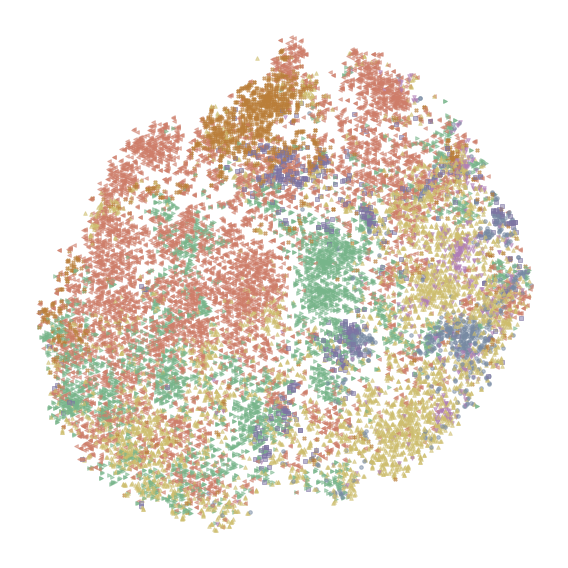

In [76]:
plot_tsne("kmeans")

## RDoC

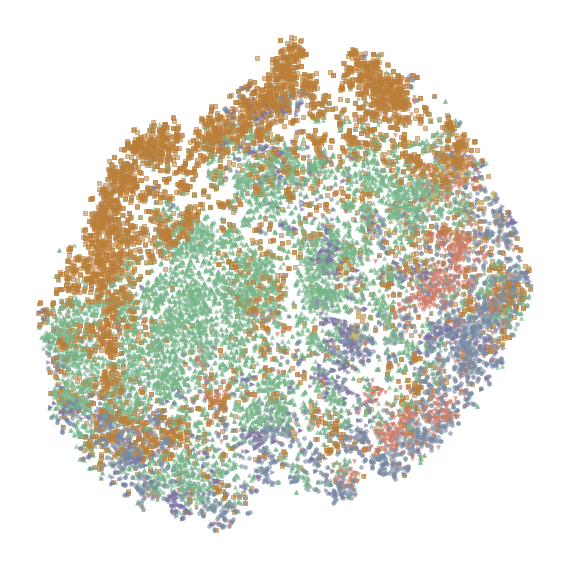

In [77]:
plot_tsne("rdoc")

## DSM

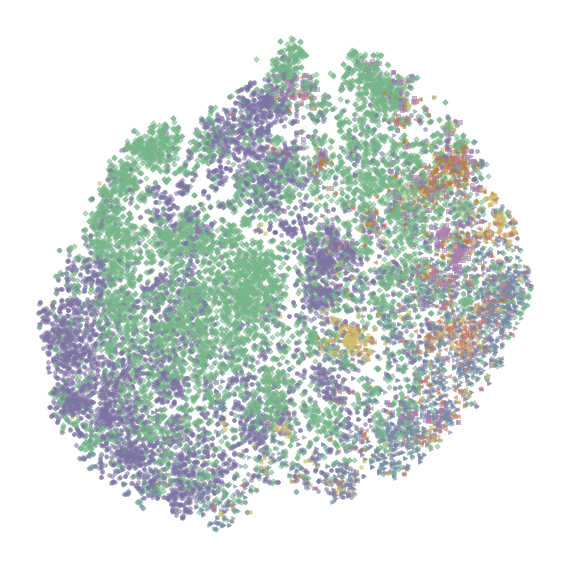

In [78]:
plot_tsne("dsm")